In [ ]:
# default_exp model.train

# Train 

> API details.

In [ ]:
#hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [ ]:
#export
import os

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
path_inputs = '../data/processed/input.npy'
path_targets = '../data/processed/target.npy'

In [ ]:
inputs = np.load(path_inputs)
targets = np.load(path_targets)

inputs.shape, targets.shape

((24, 100, 100, 7), (24, 100, 100, 1))

In [ ]:
targets_scaled = targets*1e4
targets_scaled.shape

(24, 100, 100, 1)

In [ ]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs[:, :, :, :5], targets_scaled, test_size=0.2, random_state=1)

inputs_train.shape, inputs_test.shape

((19, 100, 100, 5), (5, 100, 100, 5))

In [ ]:
class GoogleNetLayer(tf.keras.layers.Layer):
    def __init__(self, n_filters, kernel_sizes, strides, name, dtype='float32', autocast=False, **kwargs):
        super(GoogleNetLayer, self).__init__(name=name, dtype=dtype, **kwargs)

        default_params = dict(filters=n_filters, strides=strides, padding='same', activation='relu')

        self.conv1 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[0], **default_params)
        self.conv2 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[1], **default_params)
        self.conv3 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[2], **default_params)
        self.concat = tf.keras.layers.Concatenate()
    
    def call(self, inputs):
        c1 = self.conv1(inputs)
        c2 = self.conv1(inputs)
        c3 = self.conv1(inputs)
        return self.concat([c1, c2, c3])

In [ ]:
class GoogleNetTransposedLayer(tf.keras.layers.Layer):
    def __init__(self, n_filters, kernel_sizes, strides, name, dtype='float32', **kwargs):
        super(GoogleNetTransposedLayer, self).__init__(name=name, dtype=dtype, **kwargs)

        default_params = dict(filters=n_filters, strides=strides, padding='same', activation='relu')

        self.convt1 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[0], **default_params)
        self.convt2 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[1], **default_params)
        self.convt3 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[2], **default_params)
        self.concat = tf.keras.layers.Concatenate()
    
    def call(self, inputs):
        c1 = self.convt1(inputs)
        c2 = self.convt1(inputs)
        c3 = self.convt1(inputs)
        return self.concat([c1, c2, c3])

In [ ]:
class UnetModel(tf.keras.Model):
    def __init__(self):
        super(UnetModel, self).__init__()
        self.d1 = GoogleNetLayer(16, kernel_sizes, strides=(1,1), name='d1')
        self.d2 = GoogleNetLayer(32, kernel_sizes, strides=(2,2), name='d2')
        self.d3 = GoogleNetLayer(64, kernel_sizes, strides=(2,2), name='d3')
        self.d4 = GoogleNetLayer(128, kernel_sizes, strides=(1,1), name='d4')

        self.u4 = GoogleNetTransposedLayer(64, kernel_sizes, strides=(2,2), name='u4')
        self.u3 = GoogleNetTransposedLayer(32, kernel_sizes, strides=(2,2), name='u3')
        self.u2 = GoogleNetTransposedLayer(16, kernel_sizes, strides=(1,1), name='u2')

        self.u1 = tf.keras.layers.Conv2D(1, (1,1), activation='linear', padding='same', name='u1')

        self.concat1 = tf.keras.layers.Concatenate()
        self.concat2 = tf.keras.layers.Concatenate()

    def call(self, inputs):
        x1 = self.d1(inputs)
        x2 = self.d2(x1)
        x3 = self.d3(x2)
        x4 = self.d4(x3)

        x5 = self.u4(x4)
        x5 = self.concat1([x5, x2])
        
        x6 = self.u3(x5)
        x7 = self.u2(x6)
        x7 = self.concat2([x1, x7])

        return self.u1(x7)

In [ ]:
# UnetModel().call(inputs_train).shape
model = UnetModel()
model.build((None, 100, 100, 5))
model.summary()
# inputs_train.shape

Model: "unet_model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d1 (GoogleNetLayer)          multiple                  736       
_________________________________________________________________
d2 (GoogleNetLayer)          multiple                  13856     
_________________________________________________________________
d3 (GoogleNetLayer)          multiple                  55360     
_________________________________________________________________
d4 (GoogleNetLayer)          multiple                  221312    
_________________________________________________________________
u4 (GoogleNetTransposedLayer multiple                  221248    
_________________________________________________________________
u3 (GoogleNetTransposedLayer multiple                  82976     
_________________________________________________________________
u2 (GoogleNetTransposedLayer multiple                

In [ ]:
# kernel_sizes = [(3,3), (5,5), (7,7)]

# model = tf.keras.models.Sequential([
#     GoogleNetLayer(16, kernel_sizes, strides=(1,1), name='d1', input_shape=inputs_train.shape[1:]),
#     GoogleNetLayer(32, kernel_sizes, strides=(2,2), name='d2'),
#     GoogleNetLayer(64, kernel_sizes, strides=(2,2), name='d3'),
#     GoogleNetLayer(128, kernel_sizes, strides=(1,1), name='d4'),
#     GoogleNetTransposedLayer(64, kernel_sizes, strides=(2,2), name='u4'),
#     GoogleNetTransposedLayer(32, kernel_sizes, strides=(2,2), name='u3'),
#     GoogleNetTransposedLayer(16, kernel_sizes, strides=(1,1), name='u2'),
#     tf.keras.layers.Conv2D(1, (1,1), padding='same', name='u5')
# ])

# model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)

model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])

In [ ]:
tf.keras.backend.set_value(model.optimizer.lr, 1e-4)

In [ ]:
model.fit(
    inputs_train, 
    targets_train, 
    epochs=1000,
    validation_data=(inputs_test, targets_test),
    validation_freq=5
)

=================] - 0s 68ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0514 - val_loss: 0.0149 - val_mse: 0.0149 - val_mae: 0.0876
Epoch 836/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0495
Epoch 837/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0483
Epoch 838/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0460
Epoch 839/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0450
Epoch 840/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0476 - val_loss: 0.0145 - val_mse: 0.0145 - val_mae: 0.0870
Epoch 841/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0488
Epoch 842/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0482
Epoch 843/1000
1/1 [=============================

In [ ]:
%%time
preds_test = model.predict(inputs_test)
preds_train = model.predict(inputs_train)

Wall time: 685 ms


In [ ]:
def plot_example(targ, pred):
    vmax = min(np.max(pred), np.max(targ))
    vmin = min(np.min(pred), np.min(targ))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
    ax0.imshow(np.squeeze(pred), vmin=vmin, vmax=vmax)
    ax0.set_title('prediction')

    im = ax1.imshow(np.squeeze(targ), vmin=vmin, vmax=vmax)
    ax1.set_title('target')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    # plt.colorbar();

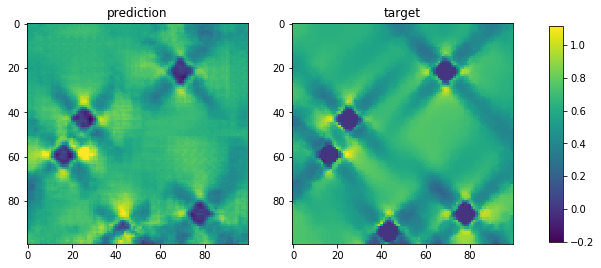

In [ ]:
idx = 1
plot_example(targets_test[idx], preds_test[idx])

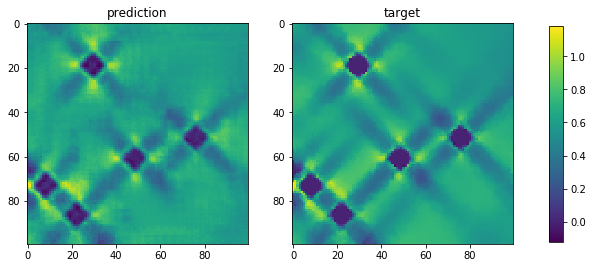

In [ ]:
idx = 4
plot_example(targets_train[idx], preds_train[idx])

In [ ]:
# for i in range(7):
#     plt.figure()
#     plt.imshow(np.squeeze(np.squeeze(inputs)[1, :, :, i]))
#     plt.colorbar();

In [ ]:
inputs.max()

100.0